# Prática VI

Eduardo Garcia Misiuk - 9293230 
Mauricio Caetano da Silva - 9040996

Dataset escolhido: Titanic

# Titanic

### Carregando os dados

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

att = ['Survived','Pclass','Age','SibSp','Parch','Fare']
titanic = pd.read_csv('titanic.csv', usecols=att)

separator = "\n============================================================================================================\n"
columns = titanic.columns.tolist()

titanic.head(n=10)



,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500
5,0,3,NaN,0,0,8.4583
6,0,1,54.0,0,0,51.8625
7,0,3,2.0,3,1,21.0750
8,1,3,27.0,0,2,11.1333
9,1,2,14.0,1,0,30.0708


### Questão 1

**Defina quais os atributos você utilizará, e a medida de avaliação você acha adequada e explique o porquê dessas escolhas.**

**Lembre-se que o objetivo da classificação é fazer predições para dados não visto, ou seja, quando o algoritmo for colocado em produção ele classificará corretamente amostras não vistas.**

Os atributos escolhidos foram:

- Survived
- Pclass
- Age
- SibSp
- Parch
- Fare

Os atributos foram escolhidos pois queremos descobrir se fatores economicos (como a classe da passagem) ou sociais (como idade) interferiram na sobrevivência de um passageiro.

Para avaliar a classificação dos algoritmos inicialmente utilizaremos como métrica o F1 score, que combina os conceitos de precisão e sensibilidade (recall), de modo a trazer um número único que indica a qualidade geral do modelo e trabalha bem até com conjuntos de dados que possuem classes desproporcionais.
Posteriormente analisaremos outras medidas de desempenho.

### Questão 2

**Uma boa prática é escolher modelos mais simples, dados dois modelos com desempenho similar a
escolha do mais simples é indicada pois com isso há algumas garantias de melhor generalização.
Generalização, de maneira geral, é a propriedade que garante que o classificador terá desempenho
parecido ao reportado no teste.**

**A definição da complexidade de um modelo nem sempre é uma tarefa fácil. Uma maneira de tentar
mensurar isso é através do número de parâmetros do modelo, do tipo de função que ele implementa
(linear ou não linear, cortes ortogonais no espaço, ...), ou da chamada dimensão VC (VapnikChervonenkis)
do classificador. A dimensão VC é um tópico mais avançado e faz parte da chamada
teoria do aprendizado estatístico, ela é citada aqui apenas como curiosidade não é esperado que saibem
sobre isso.**

**Execute a função classificacao definida no notebook com a medida de desempenho que você definiu
(caso necessário implemente ela, tem um exemplo no código de como fazer isso). Diga qual o modelo
tem o melhor desempenho e explique porque você acha isso.**

### Função de classificação

In [55]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
    
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}


### Função de classificação - amostras de bootstrap

In [56]:

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
def classificacao_bootstrap(bootstrap_dts, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(bootstrap_dts[0]), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(bootstrap_dts[0])*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')

    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']


    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for dt_boot in bootstrap_dts:

            # separa 80% para treino e 20% para teste
            test = dt_boot.sample(n=int(N_samples*0.2), replace=False)
            train = dt_boot.iloc[-test.index]

            # faz o treino do modelo
            clf = c.fit(X=train.iloc[:, columns], y=train.iloc[:, target])

            # valores predito pelo classificador
            y_pred = clf.predict(test.iloc[:, columns])
            # rótulos verdadeiros convertidos para array
            y_test = np.array(test.iloc[:, target])

            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )

    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}


### Uso da função de classificação utilizando como medida de desempenho a acurária, precisão média e f1 score.

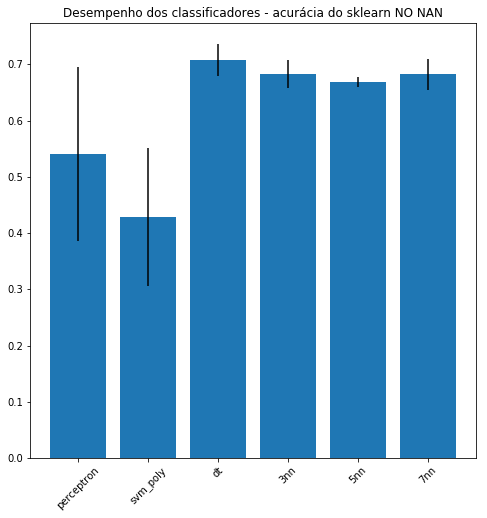

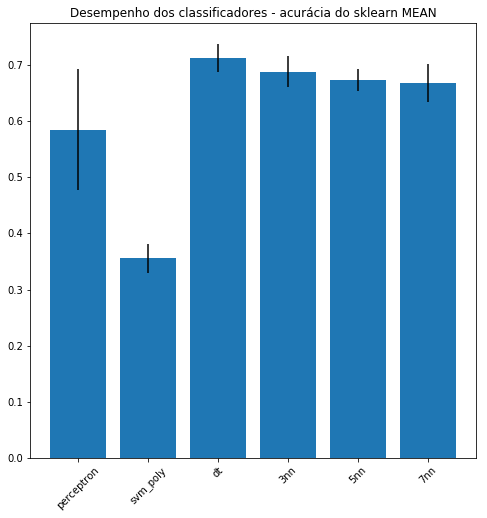

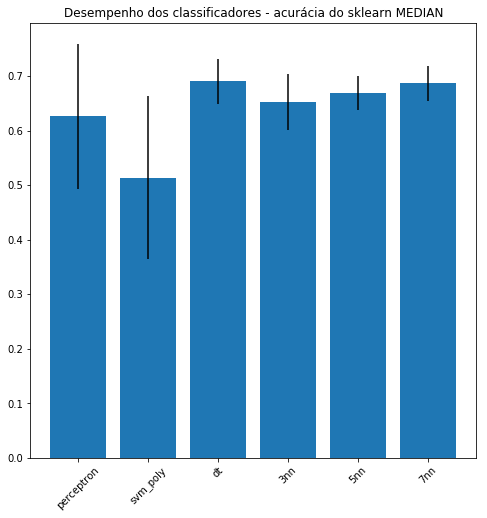

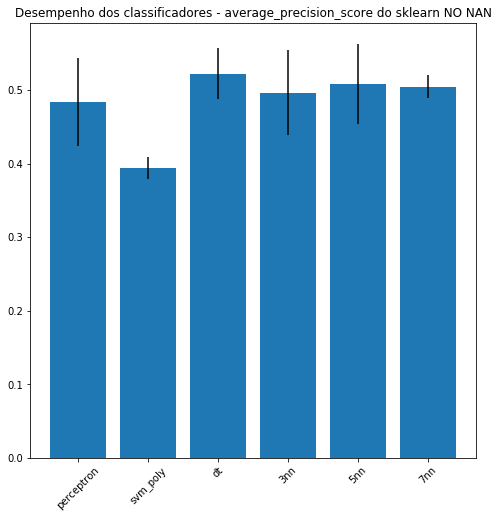

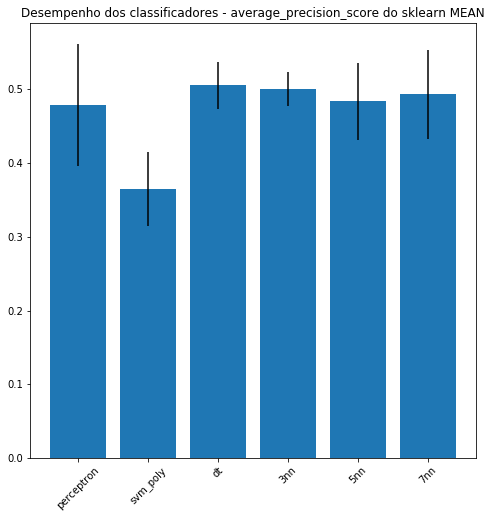

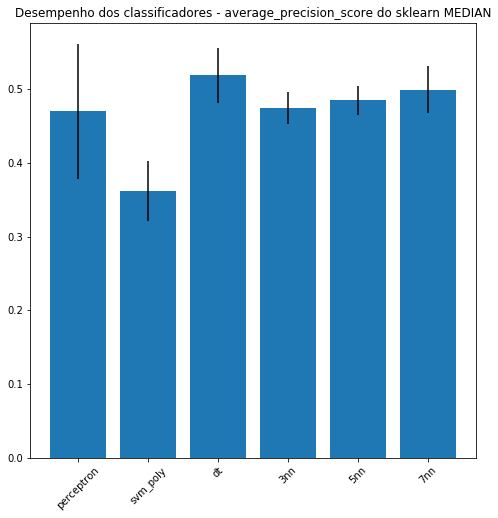

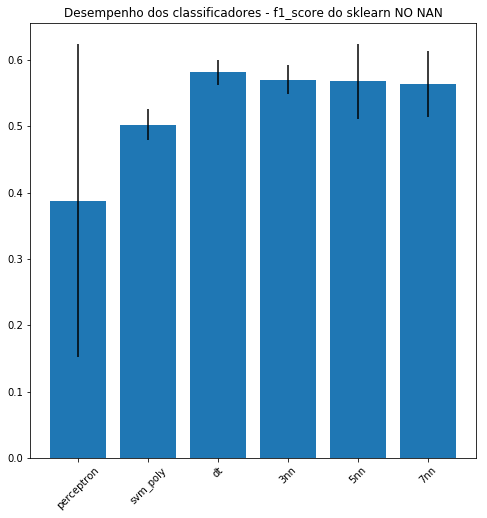

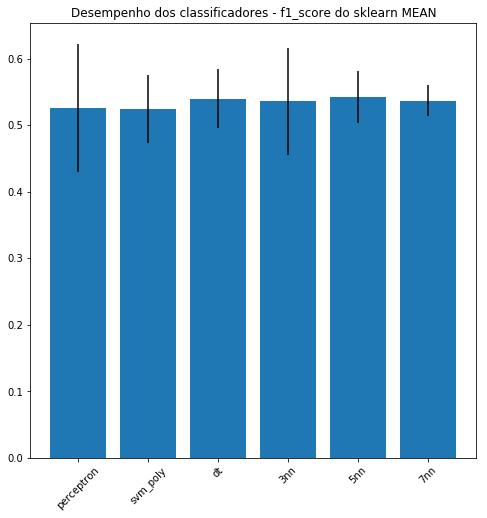

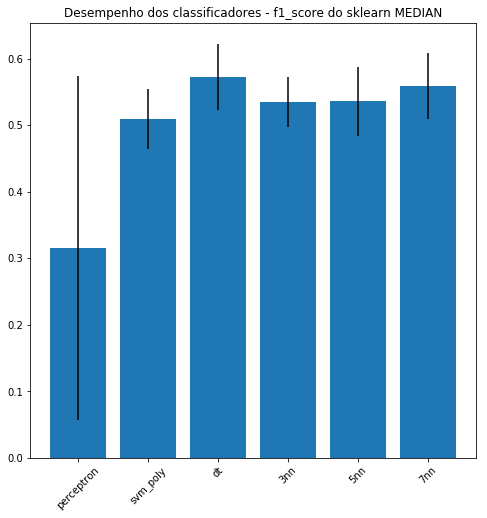

In [33]:
import seaborn as sns

# Coluna de interesse "Survived"
target = 0
# Cria um array com o número das demais colunas 1 - 5
columns_num = list(range(1,len(columns)))

# Importa as funções de medida de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

# O classificador não funciona com valores NaN no dataframe, então, estes devem ser eliminados
# Dataframe sem os valores NaN
clean = titanic.dropna()

# Dataframe com os valores NaN substituídos pela média
clean_mean = titanic.copy()
clean_mean.fillna(value=titanic.mean(), axis=0, inplace=True)

# Dataframe com os valores NaN substituídos pela mediana
clean_median = titanic.copy()
clean_median.fillna(value=titanic.median(), axis=0, inplace=True)

# Acurácia
clf_acc_clean = classificacao(clean, columns_num, target, accuracy_score, 'acurácia do sklearn NO NAN')
clf_acc_mean = classificacao(clean_mean, columns_num, target, accuracy_score, 'acurácia do sklearn MEAN')
clf_acc_median = classificacao(clean_median, columns_num, target, accuracy_score, 'acurácia do sklearn MEDIAN')

# Precisão
clf_avg_prec_clean = classificacao(clean, columns_num, target, average_precision_score, 'average_precision_score do sklearn NO NAN')
clf_avg_prec_mean = classificacao(clean_mean, columns_num, target, average_precision_score, 'average_precision_score do sklearn MEAN')
clf_avg_prec_median = classificacao(clean_median, columns_num, target, average_precision_score, 'average_precision_score do sklearn MEDIAN')

# F1 Score
clf_f1_clean = classificacao(clean, columns_num, target, f1_score, 'f1_score do sklearn NO NAN')
clf_f1_mean = classificacao(clean_mean, columns_num, target, f1_score, 'f1_score do sklearn MEAN')
clf_f1_median = classificacao(clean_median, columns_num, target, f1_score, 'f1_score do sklearn MEDIAN')


Como a função de classificação utilizada não admite valores NaN, fizemos experimentos substituindo esses dados inválidos pela média ou pela mediana do atributo correspondente. Nosso objetivo era estudar uma possível melhora do desempenho do algoritmo de classificação. 

Além disso, como na questão 1 a escolha da medida de desempenho f1 score foi feita "as cegas", preferimos observar o comportamento da acurácia e da precisão média dos classificadores.

O que foi observado é que a substituição dos valores NaN pela média e mediana trouxe, na maioria dos casos, uma melhora nas 3 medidas de desempenho.

Por fim, achamos que a medida f1 score é a mais confiável para se trabalhar pois a acurácia e a precisão são suscetíveis a desbalanceamentos do conjunto de dados e podem facilmente induzir a uma conclusão errada sobre o desempenho do sistema.

### Questão 3

**Implementar os procedimentos de amostragem para estimação do desempenho:**
- **10-fold Cross Validation;**
- **Leave-one-out;**
- **Boostrap (1000 amostras de boostrap).**

**Faça sub e superamostragem do seu dataset para gerar dois outros datasets, um com ~200 amostras e outro com ~2000 amostras. Tente fazer essa amostragem mantendo a distribuição das classes.**


**Para os dois datasets criados executar as três maneiras de estimar o desempenho. Avalie a diferença na variãncia entre essas abordagens.**

**Para o 10-fold Cross Validation e o leave-one-out você pode utilizar a função classificacao já disponível apenas ajustando o parâmetro folds. No boostrap utilize 80% do dataset para treino e 20% para teste.**

**Essas execuções podem demorar um pouco, então tenham paciência.**

**No notebook tem exemplos de como fazer isso.**

In [57]:
print('Distribuição de classes original')
print(clean.iloc[:, 0].groupby(clean.iloc[:, 0]).count())

Distribuição de classes original
Survived
0    424
1    290
Name: Survived, dtype: int64


In [59]:
cp = titanic.copy()
cp = cp.dropna()

# Número de amostras criadas para bootstrap, subamostragem e superamostragem, respectivamente
bootstrap_samples = 1000
sub_samples = 200
sup_samples = 2000

# N_samples guarda o número de linhas da base titanic (sem os valores NaN)
N_samples = cp.shape[0]

# Bootstrap
bootstrap_dataset = [cp.sample(n=N_samples, replace=True) for i in range(bootstrap_samples)]
# Subamostragem
sub_dataset = [cp.sample(n=N_samples, replace=True) for i in range(sub_samples)]
# Superamostragem
sup_dataset = [cp.sample(n=N_samples, replace=True) for i in range(sup_samples)]


# SUB_DATASET
# 10-fold cross validation
clf_10fold = classificacao_bootstrap(sub_dataset, columns_num, target, accuracy_score, 'acurária do sklearn no 10-FOLD CROSSVALIDATION NO NAN', folds=10)

# leave-one-out
#clf_loo_acc = classificacao_bootstrap(sub_dataset, columns_num, target, accuracy_score, 'acurácia no LEAVE-ONE-OUT NO NAN', folds=N_samples)
# Classificação bootstrap
# clf_boot_acc = classificacao_bootstrap(bootstrap_dataset, columns_num, target, accuracy_score, 'acurácia do sklearn com Bootstrap NO NAN')

# SUP_DATASET
# 10-fold cross validation
#clf_10fold = classificacao(sup_dataset, columns_num, target, accuracy_score, 'acurária do sklearn no 10-FOLD CROSSVALIDATION NO NAN', folds=10)
# leave-one-out
#clf_loo_acc = classificacao(sup_dataset, columns_num, target, accuracy_score, 'acurácia no LEAVE-ONE-OUT NO NAN', folds=N_samples)
# Classificação bootstrap
#clf_boot_acc = classificacao_bootstrap(bootstrap_dataset, columns_num, target, accuracy_score, 'acurácia do sklearn com Bootstrap NO NAN')

IndexError: positional indexers are out-of-bounds

### Questão 4

**Escolher um dos procedimentos da questão anterior (10-fold cross validation, leave-one-out ou bootstrap) e  calcular as medidas de avaliação baseadas na matriz de confusão (TFP, TFN, TVN, TVP).**

**Como em meio a tantas medidas de avaliação, comparar os classificadores? Como escolher o melhor?**

Encontramos problemas para desenvolver o código da questão 3, como pode ser visto acima. Não sabemos ao certo qual o problema que estamos enfrentando e por esse motivo não pudemos fazer a questão 4.

Mesmo assim, deixamos o código disponível para visualização.